In [1]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension
!pip install gmaps
!jupyter nbextension enable --py --sys-prefix gmaps

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


Enabling notebook extension jupyter-gmaps/extension...
      - Validating: ok


In [2]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import scipy.stats as stats
from census import Census
import gmaps
from us import states
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import statsmodels.api as sm

# Census & gmaps API Keys
from config import (census_key, gkey)
c = Census(census_key)

# Configure gmaps
gmaps.configure(api_key=gkey)

In [3]:
#Read US shootings data
usshootings_df = pd.read_csv("Resources/shootings.csv")
usshootings_df

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,WA,True,attack,Not fleeing,False,Guns
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,White,Aloha,OR,False,attack,Not fleeing,False,Guns
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,Hispanic,Wichita,KS,False,other,Not fleeing,False,Unarmed
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,White,San Francisco,CA,True,attack,Not fleeing,False,Other unusual objects
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,Hispanic,Evans,CO,False,attack,Not fleeing,False,Piercing objects
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4890,5916,Rayshard Brooks,2020-06-12,shot,Taser,27.0,M,Black,Atlanta,GA,False,attack,Foot,True,Electrical devices
4891,5925,Caine Van Pelt,2020-06-12,shot,gun,23.0,M,Black,Crown Point,IN,False,attack,Car,False,Guns
4892,5918,Hannah Fizer,2020-06-13,shot,unarmed,25.0,F,White,Sedalia,MO,False,other,Not fleeing,False,Unarmed
4893,5921,William Slyter,2020-06-13,shot,gun,22.0,M,White,Kansas City,MO,False,other,Other,False,Guns


In [4]:
#Get state names by joining US State Abreviation csv
usstates_df = pd.read_csv("Resources/US_State_Abreviation.csv")
usstates_df = usstates_df.rename(columns={"State": "state"})

usshootingsbystate_df = usshootings_df.merge(usstates_df)
usshootingsbystate_df

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category,State Name
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,WA,True,attack,Not fleeing,False,Guns,Washington
1,138,Antonio Zambrano-Montes,2015-02-10,shot and Tasered,unarmed,35.0,M,Hispanic,Pasco,WA,True,other,Foot,False,Unarmed,Washington
2,295,Jamison Childress,2015-03-19,shot,unarmed,20.0,M,White,Sumas,WA,True,attack,Not fleeing,False,Unarmed,Washington
3,393,Daniel Covarrubias,2015-04-21,shot,unarmed,37.0,M,Native,Lakewood,WA,True,other,Foot,False,Unarmed,Washington
4,431,Roark Cook,2015-05-04,shot,toy weapon,36.0,M,White,Kennewick,WA,True,attack,Not fleeing,False,Other unusual objects,Washington
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4890,5081,Christopher G. Louras,2019-10-01,shot,gun,34.0,M,White,Rutland,VT,False,attack,Car,False,Guns,Vermont
4891,1405,Dominique Silva,2016-03-24,shot,toy weapon,24.0,M,Black,Pawtucket,RI,False,attack,Foot,False,Other unusual objects,Rhode Island
4892,1621,Edward Acquisto,2016-06-13,shot,gun,80.0,M,Hispanic,Tiverton,RI,False,attack,Car,False,Guns,Rhode Island
4893,3119,Joseph Santos,2017-11-09,shot,unknown,32.0,M,White,Providence,RI,False,attack,Car,True,Unknown,Rhode Island


Shootings by race of victim

In [37]:
#Number of police shootings by race
race = usshootingsbystate_df.groupby(['race'])
race_df = pd.DataFrame(race["id"].count())
race_df

,id
race,
Asian,93
Black,1298
Hispanic,902
Native,78
Other,48
White,2476


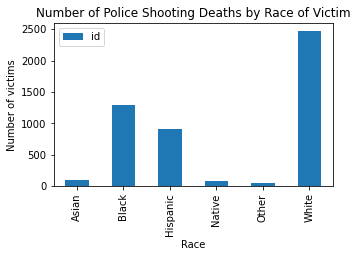

In [38]:
#Plot graph
race_df.plot(kind="bar", figsize=(5,3), title = "Number of Police Shooting Deaths by Race of Victim")
plt.ylabel("Number of victims")
plt.xlabel("Race")
plt.savefig('Images/Total_Shootings_Barchart.png',dpi=300, bbox_inches = "tight")

In [7]:
# Add a column whose default values are the expected values
race_df["expected"] = race_df["id"].sum()/6
race_df

#Find critical value
critical_value = stats.chi2.ppf(q = 0.95, df = 5)
print(f"Critical Value = {critical_value}")
# Run the chi square test with stats.chisquare()
chi = stats.chisquare(race_df['id'], race_df['expected'])
print(chi)
print(f"Since the chi square value of 5702.8 exceeds the critical value of 11.1, we conclude that the results are statistically significant.")

Critical Value = 11.070497693516351
Power_divergenceResult(statistic=5702.778549540347, pvalue=0.0)
Since the chi square value of 5702.8 exceeds the critical value of 11.1, we conclude that the results are statistically significant.


In [8]:
#Create dataframe of just unarmed 
unarmed_usshootings_df = usshootingsbystate_df[usshootingsbystate_df["arms_category"] == "Unarmed"]
unarmed_usshootings_df.reset_index(drop = True)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category,State Name
0,138,Antonio Zambrano-Montes,2015-02-10,shot and Tasered,unarmed,35.0,M,Hispanic,Pasco,WA,True,other,Foot,False,Unarmed,Washington
1,295,Jamison Childress,2015-03-19,shot,unarmed,20.0,M,White,Sumas,WA,True,attack,Not fleeing,False,Unarmed,Washington
2,393,Daniel Covarrubias,2015-04-21,shot,unarmed,37.0,M,Native,Lakewood,WA,True,other,Foot,False,Unarmed,Washington
3,4133,Nickolas Michael Peters,2018-10-23,shot,unarmed,24.0,M,White,Alderwood Manor,WA,False,attack,Car,False,Unarmed,Washington
4,4708,Ethan Austin Murray,2019-05-04,shot,unarmed,25.0,M,White,Spokane,WA,True,other,Foot,False,Unarmed,Washington
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,3825,Daniel A. Fuller,2018-07-05,shot,unarmed,26.0,M,White,Devil's Lake,ND,False,attack,Foot,True,Unarmed,North Dakota
344,5020,John Carras,2019-09-05,shot,unarmed,43.0,M,White,East Hartford,CT,False,attack,Not fleeing,False,Unarmed,Connecticut
345,5713,Jose Soto,2020-04-02,shot,unarmed,27.0,M,Hispanic,Manchester,CT,True,other,Not fleeing,False,Unarmed,Connecticut
346,1324,Abraham Mitchell Fryer,2016-02-26,shot,unarmed,35.0,M,White,Rapid Valley,SD,False,attack,Not fleeing,False,Unarmed,South Dakota


In [9]:
#Find number of unarmed police shooting deaths by race

race_unarmed = unarmed_usshootings_df.groupby(['race'])
race_unarmed_df = pd.DataFrame(race_unarmed["id"].count())


race_unarmed_df["Unarmed_%"] = ""
race_unarmed_df["Unarmed_%"] = (race_unarmed_df["id"] / race_df["id"])*100
race_unarmed_df

,id,Unarmed_%
race,,
Asian,7,7.526882
Black,123,9.476117
Hispanic,63,6.984479
Native,4,5.128205
Other,5,10.416667
White,146,5.896607


In [10]:
# Add a column whose default values are the expected values
race_unarmed_df["expected"] = race_unarmed_df["id"].sum()/6
race_unarmed_df
#Find critical value
critical_value = stats.chi2.ppf(q = 0.95, df = 5)
print(f"Critical Value = {critical_value}")
# Run the chi square test with stats.chisquare()
chi = stats.chisquare(race_unarmed_df["id"], race_unarmed_df["expected"])
print(chi)
print(f"Since the chi square value of 350.3 exceeds the critical value of 11.1, we conclude that the results are statistically significant.")

Critical Value = 11.070497693516351
Power_divergenceResult(statistic=350.34482758620686, pvalue=1.4752417781523855e-73)
Since the chi square value of 350.3 exceeds the critical value of 11.1, we conclude that the results are statistically significant.


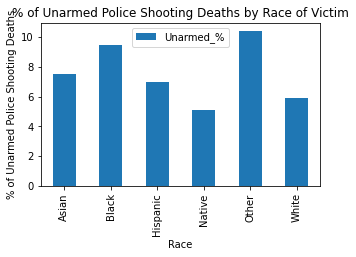

In [35]:
#Remove count of unarmed deaths by race column
race_unarmedpercent_df = race_unarmed_df.drop(columns = ["id", "expected"])
race_unarmedpercent_df

#Plot graph
race_unarmedpercent_df.plot(kind="bar", figsize=(5,3), title = "% of Unarmed Police Shooting Deaths by Race of Victim")
plt.ylabel("% of Unarmed Police Shooting Deaths")
plt.xlabel("Race")
plt.savefig('Images/Unarmed_Shootings_Barchart.png',dpi=300, bbox_inches = "tight")

Heatmaps of shootings data

In [12]:
#US Shooting of Black victims
blackvictim_shootings_df = usshootingsbystate_df[usshootingsbystate_df["race"] == "Black"]
blackvictimunarmed_shootings_df = unarmed_usshootings_df[unarmed_usshootings_df["race"] == "Black"]

In [13]:
#US Shooting of White victims
whitevictim_shootings_df = usshootingsbystate_df[usshootingsbystate_df["race"] == "White"]
whitevictimunarmed_shootings_df = unarmed_usshootings_df[unarmed_usshootings_df["race"] == "White"]

In [14]:
#US Shooting of Hispanic victims
hispanicvictim_shootings_df = usshootingsbystate_df[usshootingsbystate_df["race"] == "Hispanic"]
hispanicvictimunarmed_shootings_df = unarmed_usshootings_df[unarmed_usshootings_df["race"] == "Hispanic"]

In [15]:
#Create dataframe of shooting data grouped by state

totalstateshootings = usshootingsbystate_df.groupby(['State Name'])["id"].count()
unarmedstateshootings = unarmed_usshootings_df.groupby(['State Name'])["id"].count()
totalstateblackshootings = blackvictim_shootings_df.groupby(['State Name'])["id"].count()
totalstateblackunarmedshootings = blackvictimunarmed_shootings_df.groupby(['State Name'])["id"].count()
totalstatewhiteshootings = whitevictim_shootings_df.groupby(['State Name'])["id"].count()
totalstatewhiteunarmedshootings = whitevictimunarmed_shootings_df.groupby(['State Name'])["id"].count()
totalstatehispanicshootings = hispanicvictim_shootings_df.groupby(['State Name'])["id"].count()
totalstatehispanicunarmedshootings = hispanicvictimunarmed_shootings_df.groupby(['State Name'])["id"].count()

state_shooting_df = pd.DataFrame({"Total_Shootings" : totalstateshootings.astype(float), "Unarmed_Shootings_%" : (unarmedstateshootings/totalstateshootings)*100, 
              "Black_Victims_%" : (totalstateblackshootings/totalstateshootings)*100, "Unarmed_Black_Victims_%" : (totalstateblackunarmedshootings/totalstateshootings)*100,
              "White_Victims_%" : (totalstatewhiteshootings/totalstateshootings)*100, "Unarmed_White_Victims_%" : (totalstatewhiteunarmedshootings/totalstateshootings)*100,
              "Hispanic_Victims_%" : (totalstatehispanicshootings/totalstateshootings)*100, "Unarmed_Hispanic_Victims_%" : (totalstatehispanicunarmedshootings/totalstateshootings)*100}).fillna(0).reset_index().rename(columns={"State Name": "State"})
state_shooting_df.head()

,State,Total_Shootings,Unarmed_Shootings_%,Black_Victims_%,Unarmed_Black_Victims_%,White_Victims_%,Unarmed_White_Victims_%,Hispanic_Victims_%,Unarmed_Hispanic_Victims_%
0,Alabama,95.0,4.210526,32.631579,2.105263,66.315789,2.105263,1.052632,0.000000
1,Alaska,36.0,8.333333,8.333333,0.000000,61.111111,8.333333,0.000000,0.000000
2,Arizona,222.0,7.207207,7.657658,1.351351,49.099099,3.603604,37.387387,2.252252
3,Arkansas,73.0,4.109589,35.616438,2.739726,63.013699,1.369863,0.000000,0.000000
4,California,701.0,8.131241,17.403709,1.854494,31.526391,1.997147,45.078459,3.851641


In [16]:
#Merge centroid data to get latitude and longtitude of states
centroid_df = pd.read_csv("Resources/state_centroids.csv")
statecentroid_shooting_df = pd.merge(state_shooting_df, centroid_df, how="left", on="State")

statecentroid_shooting_df.to_csv('Resources/shootingdata_bystate.csv', index=False)
statecentroid_shooting_df.head()

,State,Total_Shootings,Unarmed_Shootings_%,Black_Victims_%,Unarmed_Black_Victims_%,White_Victims_%,Unarmed_White_Victims_%,Hispanic_Victims_%,Unarmed_Hispanic_Victims_%,Latitude,Longitude
0,Alabama,95.0,4.210526,32.631579,2.105263,66.315789,2.105263,1.052632,0.000000,32.7794,-86.8287
1,Alaska,36.0,8.333333,8.333333,0.000000,61.111111,8.333333,0.000000,0.000000,64.0685,-152.2782
2,Arizona,222.0,7.207207,7.657658,1.351351,49.099099,3.603604,37.387387,2.252252,34.2744,-111.6602
3,Arkansas,73.0,4.109589,35.616438,2.739726,63.013699,1.369863,0.000000,0.000000,34.8938,-92.4426
4,California,701.0,8.131241,17.403709,1.854494,31.526391,1.997147,45.078459,3.851641,37.1841,-119.4696


In [17]:
#Normalise data in statecentroid_shooting_df
statecentroid_shootingnormalised_df = statecentroid_shooting_df.copy()

scaler=MinMaxScaler(feature_range=(0.01,1))
statecentroid_shootingnormalised_df[["Total_Shootings", "Unarmed_Shootings_%", "Black_Victims_%", "Unarmed_Black_Victims_%", "White_Victims_%", "Unarmed_White_Victims_%", "Hispanic_Victims_%", "Unarmed_Hispanic_Victims_%"]]=(scaler.fit_transform(statecentroid_shootingnormalised_df[["Total_Shootings", "Unarmed_Shootings_%", "Black_Victims_%", "Unarmed_Black_Victims_%", "White_Victims_%", "Unarmed_White_Victims_%", "Hispanic_Victims_%", "Unarmed_Hispanic_Victims_%"]])*100)

statecentroid_shootingnormalised_df.to_csv('Resources/normalised_shootingdata_bystate.csv', index=False)
statecentroid_shootingnormalised_df.head()

,State,Total_Shootings,Unarmed_Shootings_%,Black_Victims_%,Unarmed_Black_Victims_%,White_Victims_%,Unarmed_White_Victims_%,Hispanic_Victims_%,Unarmed_Hispanic_Victims_%,Latitude,Longitude
0,Alabama,13.925395,23.926316,35.997368,27.573684,63.873684,12.463158,2.514309,1.000000,32.7794,-86.8287
1,Alaska,5.545194,46.375000,9.937500,1.000000,58.291667,46.375000,1.000000,1.000000,64.0685,-152.2782
2,Arizona,31.964132,40.243243,9.212838,18.057432,45.408784,20.621622,54.785262,29.986486,34.2744,-111.6602
3,Arkansas,10.800574,23.376712,39.198630,35.582192,60.332192,8.458904,1.000000,1.000000,34.8938,-92.4426
4,California,100.000000,45.274608,19.665478,24.408345,26.562054,11.874465,65.849590,50.570613,37.1841,-119.4696


In [18]:
#Create heatmap of total shootings
locations = statecentroid_shootingnormalised_df[["Latitude", "Longitude"]].astype(float)
total_shootings = statecentroid_shootingnormalised_df["Total_Shootings"].astype(float)

fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=total_shootings, 
                                 dissipating=False, max_intensity=50,
                                 point_radius = 3)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [19]:
#Create heatmap of unarmed shootings
unarmed_shootings = statecentroid_shootingnormalised_df["Unarmed_Shootings_%"].astype(float)
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=unarmed_shootings, 
                                 dissipating=False, max_intensity=75,
                                 point_radius = 3)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [20]:
#Create heatmap of black victim shootings
locations = statecentroid_shootingnormalised_df[["Latitude", "Longitude"]].astype(float)
blackvictim_shootings = statecentroid_shootingnormalised_df["Black_Victims_%"].astype(float)
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=blackvictim_shootings, 
                                 dissipating=False, max_intensity=75,
                                 point_radius = 3)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [21]:
#Create heatmap of black unarmed victim shootings
unarmedblackvictim_shootings = statecentroid_shootingnormalised_df["Unarmed_Black_Victims_%"].astype(float)
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=unarmedblackvictim_shootings, 
                                 dissipating=False, max_intensity=75,
                                 point_radius = 3)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [22]:
#Create heatmap of white victim shootings
whitevictim_shootings = statecentroid_shootingnormalised_df["White_Victims_%"].astype(float)
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=whitevictim_shootings, 
                                 dissipating=False, max_intensity=75,
                                 point_radius = 3)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [23]:
#Create heatmap of white unarmed victim shootings
unarmedwhitevictim_shootings = statecentroid_shootingnormalised_df["Unarmed_White_Victims_%"].astype(float)
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=unarmedwhitevictim_shootings, 
                                 dissipating=False, max_intensity=75,
                                 point_radius = 3)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [24]:
#Create heatmap of hispanic victim shootings
hispanicvictim_shootings = statecentroid_shootingnormalised_df["Hispanic_Victims_%"].astype(float)
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=hispanicvictim_shootings, 
                                 dissipating=False, max_intensity=75,
                                 point_radius = 3)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [25]:
#Create heatmap of hispanic unarmed victim shootings
unarmedhispanicvictim_shootings = statecentroid_shootingnormalised_df["Unarmed_Hispanic_Victims_%"].astype(float)
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=unarmedhispanicvictim_shootings, 
                                 dissipating=False, max_intensity=75,
                                 point_radius = 3)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

Create dataframe with census data

In [26]:
# Run Census Search to retrieve data on all states
# Note the addition of "B23025_005E" for unemployment count
census_data = c.acs5.get(("NAME", "B02001_003E", "B01003_001E", "B02001_002E", "B03001_003E",
                          "B17001_002E","B17001B_002E", "B17001A_002E","B17001I_002E",
                          "B23025_005E"), {'for': 'state:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B02001_003E": "Black_Population",
                                      "B02001_002E": "White_Population",
                                      "B03001_003E": "Hispanic_Population",
                                      "B17001_002E": "Poverty_Count",
                                      "B17001B_002E" : "Black_Poverty_Count",
                                      "B17001A_002E" : "White_Poverty_Count",
                                      "B17001I_002E" : "Hispanic_Poverty_Count",
                                      "B23025_005E": "Unemployment_Count",
                                      "NAME": "Name", "state": "State"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty_Rate"] = 100 * (census_pd["Poverty_Count"].astype(int) / census_pd["Population"].astype(int))

# Add in Employment Rate (Employment Count / Population)
census_pd["Unemployment_Rate"] = 100 * (census_pd["Unemployment_Count"].astype(int) / census_pd["Population"].astype(int))

# Add in Black Population percentage (Black Population / Population)
census_pd["Black_Population_Percentage"] = 100 * (census_pd["Black_Population"].astype(int) / census_pd["Population"].astype(int))

# Add in White Population percentage (White Population / Population)
census_pd["White_Population_Percentage"] = 100 * (census_pd["White_Population"].astype(int) / census_pd["Population"].astype(int))

# Add in Hispanic Population percentage (Hispanic Population / Population)
census_pd["Hispanic_Population_Percentage"] = 100 * (census_pd["Hispanic_Population"].astype(int) / census_pd["Population"].astype(int))

# Add in Poverty rate of black people (Black Poverty Rate / Black Population)
census_pd["Black_Poverty_Rate"] = 100 * (census_pd["Black_Poverty_Count"].astype(int) / census_pd["Black_Population"].astype(int))

# Add in Poverty rate of white people (White Poverty Rate / White Population)
census_pd["White_Poverty_Rate"] = 100 * (census_pd["White_Poverty_Count"].astype(int) / census_pd["White_Population"].astype(int))

# Add in Poverty rate of Hispanic people (Hispanic Poverty Rate / Hispanic Population)
census_pd["Hispanic_Poverty_Rate"] = 100 * (census_pd["Hispanic_Poverty_Count"].astype(int) / census_pd["Hispanic_Population"].astype(int))

# Final DataFrame
census_pd = census_pd[["State", "Name", "Population", "Black_Population_Percentage", "White_Population_Percentage", "Hispanic_Population_Percentage", "Poverty_Rate", "Unemployment_Rate", "Black_Poverty_Rate" , "White_Poverty_Rate", "Hispanic_Poverty_Rate"]]
census_pd = census_pd.drop(columns=["State"]).rename(columns={"Name": "State"}).sort_values(by=["State"]).reset_index(drop = True)
census_pd
census_pd.to_csv('Resources/Census_data.csv', index=False)

In [27]:
#Merge census dataframe and state shooting dataframe
stateshooting_census_df = pd.merge(statecentroid_shooting_df, census_pd, how="left", on="State")
stateshooting_census_df.head()

,State,Total_Shootings,Unarmed_Shootings_%,Black_Victims_%,Unarmed_Black_Victims_%,White_Victims_%,Unarmed_White_Victims_%,Hispanic_Victims_%,Unarmed_Hispanic_Victims_%,Latitude,Longitude,Population,Black_Population_Percentage,White_Population_Percentage,Hispanic_Population_Percentage,Poverty_Rate,Unemployment_Rate,Black_Poverty_Rate,White_Poverty_Rate,Hispanic_Poverty_Rate
0,Alabama,95.0,4.210526,32.631579,2.105263,66.315789,2.105263,1.052632,0.000000,32.7794,-86.8287,4864680.0,26.583167,68.194681,4.175938,17.049426,3.040241,27.374948,12.568739,31.446841
1,Alaska,36.0,8.333333,8.333333,0.000000,61.111111,8.333333,0.000000,0.000000,64.0685,-152.2782,738516.0,3.267228,64.837322,6.930926,10.543441,3.800459,16.229433,6.974442,10.641582
2,Arizona,222.0,7.207207,7.657658,1.351351,49.099099,3.603604,37.387387,2.252252,34.2744,-111.6602,6946685.0,4.394312,77.218717,31.141645,15.722492,3.026105,20.671954,13.702511,22.698344
3,Arkansas,73.0,4.109589,35.616438,2.739726,63.013699,1.369863,0.000000,0.000000,34.8938,-92.4426,2990671.0,15.413598,77.001917,7.324510,17.064298,2.533679,29.064147,14.059909,27.013221
4,California,701.0,8.131241,17.403709,1.854494,31.526391,1.997147,45.078459,3.851641,37.1841,-119.4696,39148760.0,5.792968,60.101694,38.881377,14.016130,3.375591,20.963942,12.800800,18.876080


Linear Regressions of Census Data and Shootings Data

R squared: 0.06121277841840505
R-value: 0.2474121630365109


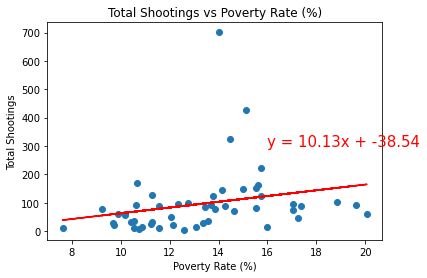

In [28]:
## Convert to floats and store Poverty Rate and Total Shootings as x and y values
x_values = stateshooting_census_df['Poverty_Rate'].astype('float')
y_values = stateshooting_census_df['Total_Shootings'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(16,300),fontsize=15,color="red")

# Label plot
plt.xlabel('Poverty Rate (%)')
plt.ylabel('Total Shootings')
plt.title('Total Shootings vs Poverty Rate (%)')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"R-value: {rvalue}")

# Show plot
plt.show()

R squared: 0.04128139296077931
R-value: 0.20317822954435671


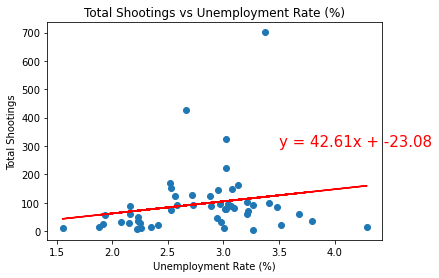

In [29]:
## Convert to floats and store Unemployment Rate and Total Shootings as x and y values
x_values = stateshooting_census_df['Unemployment_Rate'].astype('float')
y_values = stateshooting_census_df['Total_Shootings'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")


# Label plot
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Total Shootings')
plt.title('Total Shootings vs Unemployment Rate (%)')
plt.annotate(line_eq,(3.5,300),fontsize=15,color="red")

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"R-value: {rvalue}")

# Show plot
plt.show()

R squared: 0.006071150698300406
R-value: -0.0779175891458431


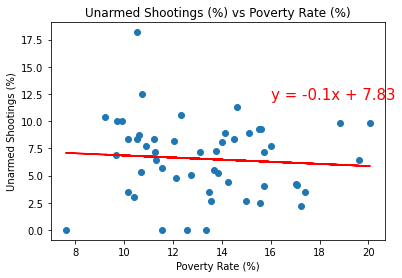

In [30]:
## Convert to floats and store Poverty Rate and Unarmed Shootings as x and y values
x_values = stateshooting_census_df['Poverty_Rate'].astype('float')
y_values = stateshooting_census_df['Unarmed_Shootings_%'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(16,12),fontsize=15,color="red")

# Label plot
plt.xlabel('Poverty Rate (%)')
plt.ylabel('Unarmed Shootings (%)')
plt.title('Unarmed Shootings (%) vs Poverty Rate (%)')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"R-value: {rvalue}")
# Show plot
plt.show()

R squared: 0.004005901339843532
R-value: -0.06329219019629145


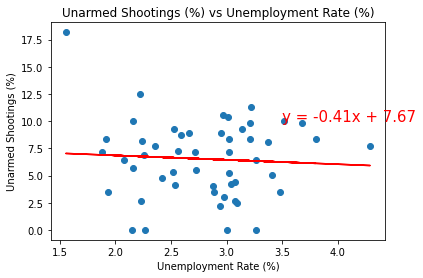

In [31]:
## Convert to floats and store Unemployment Rate and Unarmed Shootings as x and y values
x_values = stateshooting_census_df['Unemployment_Rate'].astype('float')
y_values = stateshooting_census_df['Unarmed_Shootings_%'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(3.5,10),fontsize=15,color="red")

# Label plot
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Unarmed Shootings (%)')
plt.title('Unarmed Shootings (%) vs Unemployment Rate (%)')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"R-value: {rvalue}")
# Show plot
plt.show()

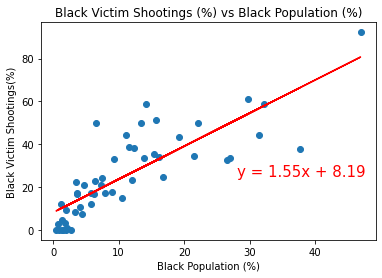

<Figure size 432x288 with 0 Axes>

In [40]:
## Convert to floats and store % of Black Population and Black Victim Shootings as x and y values
x_values = stateshooting_census_df['Black_Population_Percentage'].astype('float')
y_values = stateshooting_census_df['Black_Victims_%'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(28,25),fontsize=15,color="red")

# Label plot
plt.xlabel('Black Population (%)')
plt.ylabel('Black Victim Shootings(%)')
plt.title('Black Victim Shootings (%) vs Black Population (%)')

# Print r square value
# print(f"R squared: {rvalue**2}")
# print(f"R-value: {rvalue}")
# print(f"p-value: {pvalue}")
# Show plot
plt.show()

In [33]:
X2 = sm.add_constant(x_values)
est = sm.OLS(y_values, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        Black_Victims_%   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     101.3
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           1.63e-13
Time:                        18:40:07   Log-Likelihood:                -196.54
No. Observations:                  51   AIC:                             397.1
Df Residuals:                      49   BIC:                             400.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

R squared: 0.5942075012778917
R-value: 0.7708485592370863
p-value: 3.676763653023022e-11


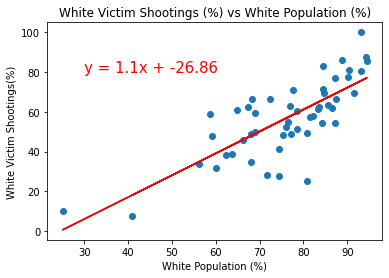

<Figure size 432x288 with 0 Axes>

In [57]:
## Convert to floats and store % of White Population and White Victim Shootings as x and y values
x_values = stateshooting_census_df['White_Population_Percentage'].astype('float')
y_values = stateshooting_census_df['White_Victims_%'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(30,80),fontsize=15,color="red")

# Label plot
plt.xlabel('White Population (%)')
plt.ylabel('White Victim Shootings(%)')
plt.title('White Victim Shootings (%) vs White Population (%)')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"R-value: {rvalue}")
print(f"p-value: {pvalue}")
# Show plot
plt.show()
plt.savefig('Images/White_Shootings_vs_White_Population.png')

In [35]:
X2 = sm.add_constant(x_values)
est = sm.OLS(y_values, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        White_Victims_%   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     71.75
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           3.68e-11
Time:                        18:40:07   Log-Likelihood:                -200.03
No. Observations:                  51   AIC:                             404.1
Df Residuals:                      49   BIC:                             407.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

R squared: 0.8342102681375966
R-value: 0.9133511198534748
p-value: 9.364263612995553e-21


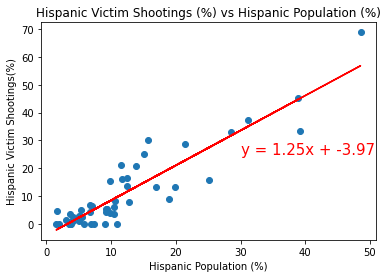

<Figure size 432x288 with 0 Axes>

In [58]:
## Convert to floats and store % of Hispanic Population and Hispanic Victim Shootings as x and y values
x_values = stateshooting_census_df['Hispanic_Population_Percentage'].astype('float')
y_values = stateshooting_census_df['Hispanic_Victims_%'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(30,25),fontsize=15,color="red")

# Label plot
plt.xlabel('Hispanic Population (%)')
plt.ylabel('Hispanic Victim Shootings(%)')
plt.title('Hispanic Victim Shootings (%) vs Hispanic Population (%)')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"R-value: {rvalue}")
print(f"p-value: {pvalue}")

# Show plot
plt.show()
plt.savefig('Images/Hispanic_Shootings_vs_Hispanic_Population.png')

In [37]:
X2 = sm.add_constant(x_values)
est = sm.OLS(y_values, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:     Hispanic_Victims_%   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     246.6
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           9.36e-21
Time:                        18:40:08   Log-Likelihood:                -160.74
No. Observations:                  51   AIC:                             325.5
Df Residuals:                      49   BIC:                             329.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

R squared: 0.4802537044662739
R-value: 0.6930033942674985
p-value: 1.7457883152206225e-08


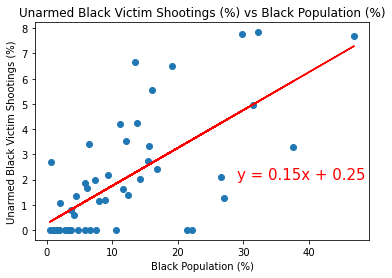

<Figure size 432x288 with 0 Axes>

In [59]:
## Convert to floats and store % of Black Population and Unarmed Black Victim Shootings as x and y values
x_values = stateshooting_census_df['Black_Population_Percentage'].astype('float')
y_values = stateshooting_census_df['Unarmed_Black_Victims_%'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(29,2),fontsize=15,color="red")

# Label plot
plt.xlabel('Black Population (%)')
plt.ylabel('Unarmed Black Victim Shootings (%)')
plt.title('Unarmed Black Victim Shootings (%) vs Black Population (%)')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"R-value: {rvalue}")
print(f"p-value: {pvalue}")
# Show plot
plt.show()
plt.savefig('Images/Unarmed_Black_Shootings_vs_Black_Population.png')

In [39]:
X2 = sm.add_constant(x_values)
est = sm.OLS(y_values, X2)
est2 = est.fit()
print(est2.summary())

                               OLS Regression Results                              
Dep. Variable:     Unarmed_Black_Victims_%   R-squared:                       0.480
Model:                                 OLS   Adj. R-squared:                  0.470
Method:                      Least Squares   F-statistic:                     45.28
Date:                     Thu, 08 Oct 2020   Prob (F-statistic):           1.75e-08
Time:                             18:40:08   Log-Likelihood:                -98.153
No. Observations:                       51   AIC:                             200.3
Df Residuals:                           49   BIC:                             204.2
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

R squared: 0.047709213320722164
R-value: 0.2184243881088423
p-value: 0.12359673463777508


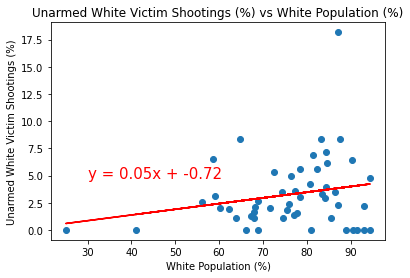

<Figure size 432x288 with 0 Axes>

In [60]:
## Convert to floats and store % of White Population and Unarmed White Victim Shootings as x and y values
x_values = stateshooting_census_df['White_Population_Percentage'].astype('float')
y_values = stateshooting_census_df['Unarmed_White_Victims_%'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(30,4.8),fontsize=15,color="red")

# Label plot
plt.xlabel('White Population (%)')
plt.ylabel('Unarmed White Victim Shootings (%)')
plt.title('Unarmed White Victim Shootings (%) vs White Population (%)')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"R-value: {rvalue}")
print(f"p-value: {pvalue}")

# Show plot
plt.show()
plt.savefig('Images/Unarmed_White_Shootings_vs_White_Population.png')

In [41]:
X2 = sm.add_constant(x_values)
est = sm.OLS(y_values, X2)
est2 = est.fit()
print(est2.summary())

                               OLS Regression Results                              
Dep. Variable:     Unarmed_White_Victims_%   R-squared:                       0.048
Model:                                 OLS   Adj. R-squared:                  0.028
Method:                      Least Squares   F-statistic:                     2.455
Date:                     Thu, 08 Oct 2020   Prob (F-statistic):              0.124
Time:                             18:40:09   Log-Likelihood:                -130.78
No. Observations:                       51   AIC:                             265.6
Df Residuals:                           49   BIC:                             269.4
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

R squared: 0.2752755915120605
R-value: 0.524667124481857
p-value: 7.741537559980572e-05


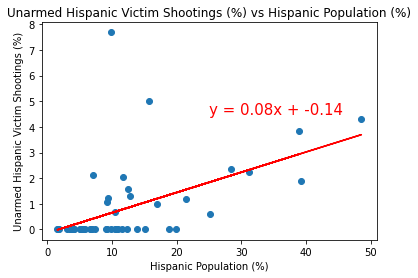

<Figure size 432x288 with 0 Axes>

In [61]:
## Convert to floats and store % of Hispanic Population and Unarmed Hispanic Victim Shootings as x and y values
x_values = stateshooting_census_df['Hispanic_Population_Percentage'].astype('float')
y_values = stateshooting_census_df['Unarmed_Hispanic_Victims_%'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(25,4.5),fontsize=15,color="red")

# Label plot
plt.xlabel('Hispanic Population (%)')
plt.ylabel('Unarmed Hispanic Victim Shootings (%)')
plt.title('Unarmed Hispanic Victim Shootings (%) vs Hispanic Population (%)')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"R-value: {rvalue}")
print(f"p-value: {pvalue}")

# Show plot
plt.show()
plt.savefig('Images/Unarmed_Black_Shootings_vs_Black_Population.png')

In [43]:
X2 = sm.add_constant(x_values)
est = sm.OLS(y_values, X2)
est2 = est.fit()
print(est2.summary())

                                OLS Regression Results                                
Dep. Variable:     Unarmed_Hispanic_Victims_%   R-squared:                       0.275
Model:                                    OLS   Adj. R-squared:                  0.260
Method:                         Least Squares   F-statistic:                     18.61
Date:                        Thu, 08 Oct 2020   Prob (F-statistic):           7.74e-05
Time:                                18:40:09   Log-Likelihood:                -85.720
No. Observations:                          51   AIC:                             175.4
Df Residuals:                              49   BIC:                             179.3
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

R squared: 0.011031099993490964
R-value: 0.1050290435712473


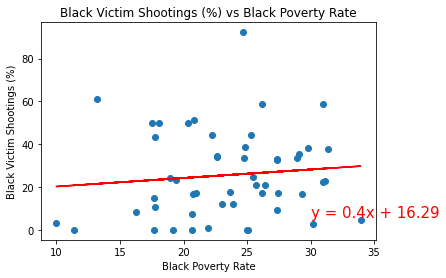

In [44]:
## Convert to floats and store Black Poverty Rate and Black Victim Shootings as x and y values
x_values = stateshooting_census_df['Black_Poverty_Rate'].astype('float')
y_values = stateshooting_census_df['Black_Victims_%'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(30,6),fontsize=15,color="red")

# Label plot
plt.xlabel('Black Poverty Rate')
plt.ylabel('Black Victim Shootings (%)')
plt.title('Black Victim Shootings (%) vs Black Poverty Rate')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"R-value: {rvalue}")
# Show plot
plt.show()

R squared: 0.028802114919668005
R-value: 0.16971185851220888


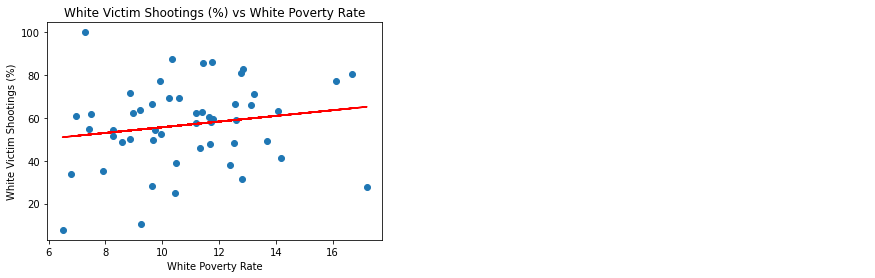

In [45]:
## Convert to floats and store White Poverty Rate and White Victim Shootings as x and y values
x_values = stateshooting_census_df['White_Poverty_Rate'].astype('float')
y_values = stateshooting_census_df['White_Victims_%'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(30,6),fontsize=15,color="red")

# Label plot
plt.xlabel('White Poverty Rate')
plt.ylabel('White Victim Shootings (%)')
plt.title('White Victim Shootings (%) vs White Poverty Rate')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"R-value: {rvalue}")
# Show plot
plt.show()

R squared: 0.00023051663302242227
R-value: 0.015182774220228077


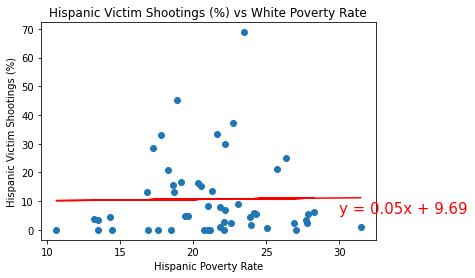

In [46]:
## Convert to floats and store Hispanic Poverty Rate and Hispanic Victim Shootings as x and y values
x_values = stateshooting_census_df['Hispanic_Poverty_Rate'].astype('float')
y_values = stateshooting_census_df['Hispanic_Victims_%'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(30,6),fontsize=15,color="red")

# Label plot
plt.xlabel('Hispanic Poverty Rate')
plt.ylabel('Hispanic Victim Shootings (%)')
plt.title('Hispanic Victim Shootings (%) vs White Poverty Rate')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"R-value: {rvalue}")
# Show plot
plt.show()

R squared: 0.005250828879732355
R-value: 0.07246260331876267


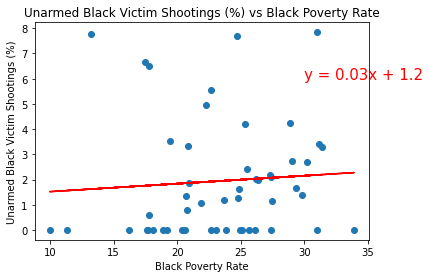

In [47]:
## Convert to floats and store Black Poverty Rate and Black Unarmed Victim Shootings as x and y values
x_values = stateshooting_census_df['Black_Poverty_Rate'].astype('float')
y_values = stateshooting_census_df['Unarmed_Black_Victims_%'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(30,6),fontsize=15,color="red")

# Label plot
plt.xlabel('Black Poverty Rate')
plt.ylabel('Unarmed Black Victim Shootings (%)')
plt.title('Unarmed Black Victim Shootings (%) vs Black Poverty Rate')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"R-value: {rvalue}")
# Show plot
plt.show()

R squared: 0.03369330696528664
R-value: -0.18355736695999603


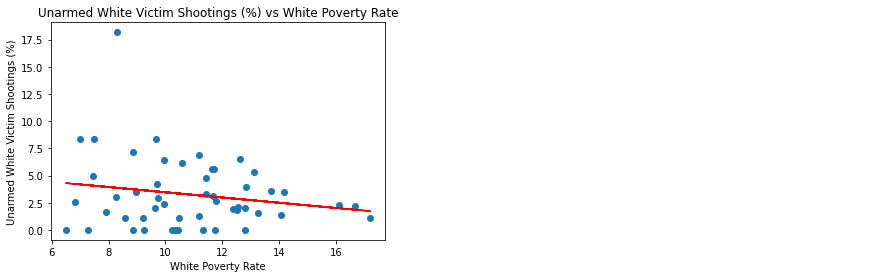

In [48]:
## Convert to floats and store White Poverty Rate and White Unarmed Victim Shootings as x and y values
x_values = stateshooting_census_df['White_Poverty_Rate'].astype('float')
y_values = stateshooting_census_df['Unarmed_White_Victims_%'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(30,6),fontsize=15,color="red")

# Label plot
plt.xlabel('White Poverty Rate')
plt.ylabel('Unarmed White Victim Shootings (%)')
plt.title('Unarmed White Victim Shootings (%) vs White Poverty Rate')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"R-value: {rvalue}")
# Show plot
plt.show()

R squared: 0.00011837834354816164
R-value: -0.010880181227726018


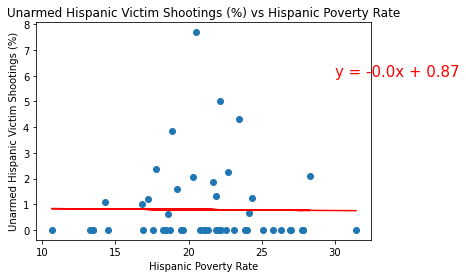

In [49]:
## Convert to floats and store Hispanic Poverty Rate and Hispanic Unarmed Victim Shootings as x and y values
x_values = stateshooting_census_df['Hispanic_Poverty_Rate'].astype('float')
y_values = stateshooting_census_df['Unarmed_Hispanic_Victims_%'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(30,6),fontsize=15,color="red")

# Label plot
plt.xlabel('Hispanic Poverty Rate')
plt.ylabel('Unarmed Hispanic Victim Shootings (%)')
plt.title('Unarmed Hispanic Victim Shootings (%) vs Hispanic Poverty Rate')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"R-value: {rvalue}")
# Show plot
plt.show()